# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [45]:
# can comment out after executing
#!unzip processed_celeba_small.zip

In [46]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [47]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms

In [48]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                  transforms.ToTensor()])
    
    dataset = datasets.ImageFolder(data_dir,transform=transform)
    
    dataloader = torch.utils.data.dataloader.DataLoader(dataset, batch_size=batch_size,shuffle=True)
        
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [49]:
# Define function hyperparameters
batch_size = 32
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

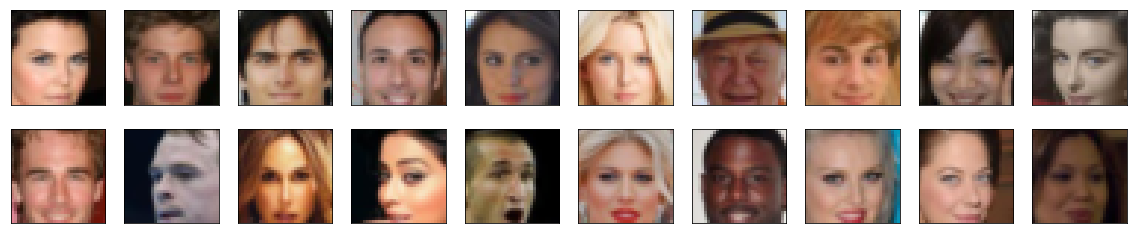

In [50]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [51]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    
    min, max = feature_range
    x = x * (max - min) + min
    
    return x


In [52]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-1.)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [53]:
def conv(in_channels, out_channels, kernal_size=3, stride =2, padding=0, batch_norm = False):
    
    layers =[]
    
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size =kernal_size, stride =stride, padding=padding, bias =False))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)
    

In [54]:
import torch.nn as nn
import torch.nn.functional as F

In [55]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        # out - 16
        self.conv1 = conv(3, conv_dim, kernal_size=4, padding=1, batch_norm=False)
        
        # out - 8
        self.conv2 = conv(conv_dim, conv_dim*2, kernal_size=4, padding=1, batch_norm=True)        
        
        # out - 4
        self.conv3 = conv(conv_dim*2, conv_dim*4, kernal_size=4, padding=1, batch_norm=True)
        
        # out - 2
        self.conv4 = conv(conv_dim*4, conv_dim*8, kernal_size=4, padding=1, batch_norm=True)        
        
        # out - 1
        self.conv5 = conv(conv_dim*8, conv_dim*16, kernal_size=4, padding=1, batch_norm=False)    
        
        self.fc = nn.Linear(conv_dim*16, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        
        out = F.leaky_relu(self.conv1(x),0.2)
        out = F.leaky_relu(self.conv2(out),0.2)
        out = F.leaky_relu(self.conv3(out),0.2)
        out = F.leaky_relu(self.conv4(out),0.2)
        out = F.leaky_relu(self.conv5(out),0.2)
        #print(out.shape)
        out = out.view(-1, self.conv_dim*16)
        
        #print(out.shape)
        
        out = self.fc(out)
        
        #print(out.shape)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [56]:
def dconv(in_channels, out_channels, kernal_size=3, stride =2, padding=0, batch_norm = False):
    
    layers =[]
    
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size =kernal_size, stride =stride, padding=padding))
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)
    

In [57]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.z_size = z_size
        
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)
        
        # out - 4
        self.dconv1 = dconv(conv_dim*8, conv_dim*4, kernal_size=4, padding=1, batch_norm=True)
        
        # out - 8
        self.dconv2 = dconv(conv_dim*4, conv_dim*2, kernal_size=4, padding=1, batch_norm=True)        
        
        # out - 16
        self.dconv3 = dconv(conv_dim*2, conv_dim, kernal_size=4, padding=1, batch_norm=True)
        
        # out - 32
        self.dconv4 = dconv(conv_dim, 3, kernal_size=4, padding=1, batch_norm=False)
        
#         # out - 2
#         self.dconv4 = dconv(conv_dim*4, conv_dim*8, kernal_size=4, padding=1, batch_norm=True)        
        
#         # out - 1
#         self.dconv5 = dconv(conv_dim*16, conv_dim*32, kernal_size=4, padding=1, batch_norm=False)    
        
                

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*8,2,2)
        
        out = F.relu(self.dconv1(out))
        out = F.relu(self.dconv2(out))
        out = F.relu(self.dconv3(out))
        out = F.tanh(self.dconv4(out))
        
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [58]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    
    if classname =='Conv2d':
        
        w = torch.empty(m.weight.data.shape)
        m.weight.data = nn.init.normal_(w,mean=0, std=0.02)
        
    if classname =='Linear':
        w = torch.empty(m.weight.data.shape)
        m.weight.data = nn.init.normal_(w,mean=0, std=0.02)     


## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [59]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [60]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=1024, bias=True)
  (dcon

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [61]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [62]:
def real_loss(D_out, smooth=False):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size)
    
    if train_on_gpu:
        labels = labels.cuda()
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [63]:
import torch.optim as optim

In [64]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999


# Create optimizers for the discriminator D and generator G
d_optimizer = optim.Adam(D.parameters(),lr = lr, betas=[beta1,beta2])
g_optimizer = optim.Adam(G.parameters(),lr = lr, betas=[beta1,beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [65]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            if train_on_gpu:
                real_images = real_images.cuda() 
            
            
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            d_real_out = D(real_images)
            
            #print(d_real_out.shape)
            
            d_real_loss = real_loss(d_real_out)
            
            
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda() 
                
            d_fake_out = G(z)
            
            d_fake_out_bloss = D(d_fake_out)
            
            #print(d_fake_out_bloss.shape)
            
            d_fake_out_loss = fake_loss(d_fake_out_bloss)
            
            #print(d_fake_out_bloss.shape)
            
            d_loss = d_real_loss + d_fake_out_loss
            
            #print(d_total_loss)
            
            d_loss.backward()
            
            d_optimizer.step()
            
            
            g_optimizer.zero_grad()
            
            # 2. Train the generator with an adversarial loss
            
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            
            if train_on_gpu:
                z = z.cuda()               
            fake_out = G(z)
            
            D_fake = D(fake_out)
            
            g_loss = real_loss(D_fake)
            
            g_loss.backward()
            
            g_optimizer.step()

            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [ ]:
# set number of epochs 
n_epochs = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function

from workspace_utils import active_session

with active_session():
    losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/  100] | d_loss: 1.4011 | g_loss: 0.7426
Epoch [    1/  100] | d_loss: 0.0637 | g_loss: 4.0001
Epoch [    1/  100] | d_loss: 0.3097 | g_loss: 6.0344
Epoch [    1/  100] | d_loss: 0.5035 | g_loss: 3.4255
Epoch [    1/  100] | d_loss: 0.1391 | g_loss: 5.4766
Epoch [    1/  100] | d_loss: 0.6205 | g_loss: 4.2346
Epoch [    1/  100] | d_loss: 0.4400 | g_loss: 4.3795
Epoch [    1/  100] | d_loss: 0.7827 | g_loss: 2.7751
Epoch [    1/  100] | d_loss: 0.9545 | g_loss: 4.3481
Epoch [    1/  100] | d_loss: 0.7136 | g_loss: 4.1280
Epoch [    1/  100] | d_loss: 0.8052 | g_loss: 3.0481
Epoch [    1/  100] | d_loss: 1.3390 | g_loss: 5.2394
Epoch [    1/  100] | d_loss: 1.1619 | g_loss: 0.8937
Epoch [    1/  100] | d_loss: 0.7450 | g_loss: 3.3485
Epoch [    1/  100] | d_loss: 0.5769 | g_loss: 3.1492
Epoch [    1/  100] | d_loss: 1.1582 | g_loss: 5.4227
Epoch [    1/  100] | d_loss: 0.7234 | g_loss: 3.1857
Epoch [    1/  100] | d_loss: 0.5417 | g_loss: 3.9817
Epoch [    1/  100] | d_loss

Epoch [    3/  100] | d_loss: 0.7184 | g_loss: 2.8219
Epoch [    3/  100] | d_loss: 0.4293 | g_loss: 3.3076
Epoch [    3/  100] | d_loss: 0.8652 | g_loss: 3.3383
Epoch [    3/  100] | d_loss: 0.9452 | g_loss: 3.8257
Epoch [    3/  100] | d_loss: 0.4315 | g_loss: 1.3823
Epoch [    3/  100] | d_loss: 0.4860 | g_loss: 2.1988
Epoch [    3/  100] | d_loss: 0.7896 | g_loss: 1.4467
Epoch [    3/  100] | d_loss: 0.5815 | g_loss: 2.8515
Epoch [    3/  100] | d_loss: 0.6235 | g_loss: 2.3184
Epoch [    3/  100] | d_loss: 0.7428 | g_loss: 2.5999
Epoch [    3/  100] | d_loss: 0.4205 | g_loss: 3.1086
Epoch [    3/  100] | d_loss: 0.6386 | g_loss: 2.3924
Epoch [    3/  100] | d_loss: 1.2109 | g_loss: 1.0453
Epoch [    3/  100] | d_loss: 1.1353 | g_loss: 2.9057
Epoch [    3/  100] | d_loss: 0.3101 | g_loss: 2.3592
Epoch [    3/  100] | d_loss: 1.1489 | g_loss: 3.5709
Epoch [    3/  100] | d_loss: 0.7934 | g_loss: 4.2106
Epoch [    3/  100] | d_loss: 1.1926 | g_loss: 1.0295
Epoch [    3/  100] | d_loss

Epoch [    6/  100] | d_loss: 1.1041 | g_loss: 6.0036
Epoch [    6/  100] | d_loss: 0.2442 | g_loss: 4.5233
Epoch [    6/  100] | d_loss: 0.5318 | g_loss: 1.2075
Epoch [    6/  100] | d_loss: 0.8078 | g_loss: 1.3279
Epoch [    6/  100] | d_loss: 0.3827 | g_loss: 2.1580
Epoch [    6/  100] | d_loss: 0.5952 | g_loss: 4.1158
Epoch [    6/  100] | d_loss: 0.7221 | g_loss: 2.6763
Epoch [    6/  100] | d_loss: 1.1956 | g_loss: 4.1327
Epoch [    6/  100] | d_loss: 1.0233 | g_loss: 2.3721
Epoch [    6/  100] | d_loss: 0.3706 | g_loss: 3.9242
Epoch [    6/  100] | d_loss: 1.7240 | g_loss: 1.9501
Epoch [    6/  100] | d_loss: 0.1584 | g_loss: 3.1508
Epoch [    6/  100] | d_loss: 0.3978 | g_loss: 3.6602
Epoch [    6/  100] | d_loss: 0.7501 | g_loss: 2.0580
Epoch [    6/  100] | d_loss: 0.6293 | g_loss: 2.1726
Epoch [    6/  100] | d_loss: 0.7089 | g_loss: 2.6383
Epoch [    6/  100] | d_loss: 0.3291 | g_loss: 3.3321
Epoch [    6/  100] | d_loss: 0.6222 | g_loss: 3.6876
Epoch [    6/  100] | d_loss

Epoch [    9/  100] | d_loss: 0.3726 | g_loss: 4.6976
Epoch [    9/  100] | d_loss: 0.5047 | g_loss: 2.2291
Epoch [    9/  100] | d_loss: 0.7465 | g_loss: 2.5647
Epoch [    9/  100] | d_loss: 0.3490 | g_loss: 3.3461
Epoch [    9/  100] | d_loss: 1.0217 | g_loss: 4.1331
Epoch [    9/  100] | d_loss: 0.3080 | g_loss: 4.3674
Epoch [    9/  100] | d_loss: 0.0925 | g_loss: 5.7314
Epoch [    9/  100] | d_loss: 0.9835 | g_loss: 2.3772
Epoch [    9/  100] | d_loss: 0.6773 | g_loss: 2.3338
Epoch [    9/  100] | d_loss: 0.5384 | g_loss: 2.9965
Epoch [    9/  100] | d_loss: 0.0949 | g_loss: 4.1300
Epoch [    9/  100] | d_loss: 0.2562 | g_loss: 2.8822
Epoch [    9/  100] | d_loss: 0.4814 | g_loss: 4.2901
Epoch [    9/  100] | d_loss: 0.3461 | g_loss: 4.5417
Epoch [    9/  100] | d_loss: 0.1760 | g_loss: 3.9933
Epoch [    9/  100] | d_loss: 0.2982 | g_loss: 4.8507
Epoch [    9/  100] | d_loss: 0.9755 | g_loss: 1.7356
Epoch [    9/  100] | d_loss: 0.4240 | g_loss: 4.2812
Epoch [    9/  100] | d_loss

Epoch [   11/  100] | d_loss: 0.4843 | g_loss: 5.4115
Epoch [   11/  100] | d_loss: 0.4516 | g_loss: 3.2951
Epoch [   11/  100] | d_loss: 0.6737 | g_loss: 2.5002
Epoch [   11/  100] | d_loss: 0.5683 | g_loss: 0.0963
Epoch [   11/  100] | d_loss: 0.4417 | g_loss: 5.9305
Epoch [   11/  100] | d_loss: 0.1662 | g_loss: 4.0401
Epoch [   11/  100] | d_loss: 0.1387 | g_loss: 6.2374
Epoch [   11/  100] | d_loss: 0.3880 | g_loss: 2.1318
Epoch [   11/  100] | d_loss: 0.3799 | g_loss: 1.8228
Epoch [   11/  100] | d_loss: 0.8460 | g_loss: 1.2995
Epoch [   11/  100] | d_loss: 0.0489 | g_loss: 3.8266
Epoch [   11/  100] | d_loss: 0.2163 | g_loss: 4.2078
Epoch [   11/  100] | d_loss: 0.6029 | g_loss: 2.9909
Epoch [   11/  100] | d_loss: 0.4655 | g_loss: 4.8093
Epoch [   11/  100] | d_loss: 0.4416 | g_loss: 2.1529
Epoch [   11/  100] | d_loss: 0.1530 | g_loss: 4.4368
Epoch [   11/  100] | d_loss: 0.3897 | g_loss: 3.6967
Epoch [   11/  100] | d_loss: 0.5349 | g_loss: 5.6362
Epoch [   11/  100] | d_loss

Epoch [   14/  100] | d_loss: 0.3132 | g_loss: 4.4756
Epoch [   14/  100] | d_loss: 0.1601 | g_loss: 5.1203
Epoch [   14/  100] | d_loss: 0.3103 | g_loss: 5.2775
Epoch [   14/  100] | d_loss: 1.1610 | g_loss: 4.3786
Epoch [   14/  100] | d_loss: 0.0578 | g_loss: 4.4038
Epoch [   14/  100] | d_loss: 0.2661 | g_loss: 5.2677
Epoch [   14/  100] | d_loss: 0.2253 | g_loss: 1.8877
Epoch [   14/  100] | d_loss: 0.1117 | g_loss: 4.7431
Epoch [   14/  100] | d_loss: 0.2280 | g_loss: 4.5238
Epoch [   14/  100] | d_loss: 0.1506 | g_loss: 5.5618
Epoch [   14/  100] | d_loss: 0.3311 | g_loss: 4.9703
Epoch [   14/  100] | d_loss: 0.3342 | g_loss: 4.9095
Epoch [   14/  100] | d_loss: 0.2758 | g_loss: 7.4234
Epoch [   14/  100] | d_loss: 0.1435 | g_loss: 2.5565
Epoch [   14/  100] | d_loss: 0.2892 | g_loss: 4.6669
Epoch [   14/  100] | d_loss: 0.3121 | g_loss: 4.1178
Epoch [   14/  100] | d_loss: 0.1369 | g_loss: 3.2332
Epoch [   14/  100] | d_loss: 0.1614 | g_loss: 6.3617
Epoch [   14/  100] | d_loss

Epoch [   17/  100] | d_loss: 0.2984 | g_loss: 4.6473
Epoch [   17/  100] | d_loss: 0.0564 | g_loss: 3.4048
Epoch [   17/  100] | d_loss: 0.1686 | g_loss: 5.1304
Epoch [   17/  100] | d_loss: 0.4946 | g_loss: 5.6539
Epoch [   17/  100] | d_loss: 0.4492 | g_loss: 6.7583
Epoch [   17/  100] | d_loss: 0.8181 | g_loss: 7.5057
Epoch [   17/  100] | d_loss: 0.6673 | g_loss: 6.2841
Epoch [   17/  100] | d_loss: 0.0602 | g_loss: 6.8328
Epoch [   17/  100] | d_loss: 0.2822 | g_loss: 2.4226
Epoch [   17/  100] | d_loss: 0.2164 | g_loss: 5.6840
Epoch [   17/  100] | d_loss: 0.2920 | g_loss: 1.9996
Epoch [   17/  100] | d_loss: 0.0360 | g_loss: 5.4658
Epoch [   17/  100] | d_loss: 0.4314 | g_loss: 6.5844
Epoch [   17/  100] | d_loss: 5.2068 | g_loss: 8.5218
Epoch [   17/  100] | d_loss: 0.1000 | g_loss: 4.5218
Epoch [   17/  100] | d_loss: 0.1282 | g_loss: 6.2544
Epoch [   17/  100] | d_loss: 0.0562 | g_loss: 6.9523
Epoch [   17/  100] | d_loss: 0.2528 | g_loss: 1.3834
Epoch [   17/  100] | d_loss

Epoch [   19/  100] | d_loss: 0.0303 | g_loss: 3.1430
Epoch [   19/  100] | d_loss: 0.0076 | g_loss: 7.7419
Epoch [   19/  100] | d_loss: 2.2774 | g_loss: 8.9469
Epoch [   19/  100] | d_loss: 0.4871 | g_loss: 7.1295
Epoch [   19/  100] | d_loss: 0.0844 | g_loss: 6.1984
Epoch [   19/  100] | d_loss: 0.3190 | g_loss: 6.8527
Epoch [   19/  100] | d_loss: 0.0237 | g_loss: 4.2836
Epoch [   19/  100] | d_loss: 0.0410 | g_loss: 6.5739
Epoch [   19/  100] | d_loss: 0.1345 | g_loss: 5.3852
Epoch [   19/  100] | d_loss: 0.3208 | g_loss: 4.9858
Epoch [   19/  100] | d_loss: 0.1212 | g_loss: 4.5383
Epoch [   19/  100] | d_loss: 0.1239 | g_loss: 3.3941
Epoch [   19/  100] | d_loss: 0.7928 | g_loss: 3.2919
Epoch [   19/  100] | d_loss: 0.3677 | g_loss: 6.4023
Epoch [   19/  100] | d_loss: 0.0878 | g_loss: 6.5434
Epoch [   19/  100] | d_loss: 0.1830 | g_loss: 2.7182
Epoch [   19/  100] | d_loss: 0.1111 | g_loss: 5.5600
Epoch [   19/  100] | d_loss: 0.1225 | g_loss: 7.2883
Epoch [   19/  100] | d_loss

Epoch [   22/  100] | d_loss: 0.1750 | g_loss: 4.0547
Epoch [   22/  100] | d_loss: 0.3556 | g_loss: 1.9924
Epoch [   22/  100] | d_loss: 0.0278 | g_loss: 3.1046
Epoch [   22/  100] | d_loss: 0.1732 | g_loss: 3.7289
Epoch [   22/  100] | d_loss: 0.0516 | g_loss: 3.4871
Epoch [   22/  100] | d_loss: 0.1506 | g_loss: 9.7714
Epoch [   22/  100] | d_loss: 0.1923 | g_loss: 6.8163
Epoch [   22/  100] | d_loss: 0.6446 | g_loss: 1.6952
Epoch [   22/  100] | d_loss: 0.0050 | g_loss: 7.5403
Epoch [   22/  100] | d_loss: 0.0295 | g_loss: 6.9812
Epoch [   22/  100] | d_loss: 0.1747 | g_loss: 6.5357
Epoch [   22/  100] | d_loss: 0.1455 | g_loss: 6.3039
Epoch [   22/  100] | d_loss: 0.0417 | g_loss: 4.3462
Epoch [   22/  100] | d_loss: 0.0784 | g_loss: 6.5242
Epoch [   22/  100] | d_loss: 0.4034 | g_loss: 1.6057
Epoch [   22/  100] | d_loss: 0.0814 | g_loss: 4.8383
Epoch [   22/  100] | d_loss: 0.0233 | g_loss: 7.8211
Epoch [   22/  100] | d_loss: 0.0366 | g_loss: 4.1332
Epoch [   22/  100] | d_loss

Epoch [   25/  100] | d_loss: 0.2585 | g_loss: 5.2204
Epoch [   25/  100] | d_loss: 0.2886 | g_loss: 5.2430
Epoch [   25/  100] | d_loss: 0.7090 | g_loss: 4.4945
Epoch [   25/  100] | d_loss: 0.5856 | g_loss: 4.8664
Epoch [   25/  100] | d_loss: 0.0150 | g_loss: 5.9606
Epoch [   25/  100] | d_loss: 0.0180 | g_loss: 7.0322
Epoch [   25/  100] | d_loss: 0.1575 | g_loss: 5.2812
Epoch [   25/  100] | d_loss: 0.0389 | g_loss: 7.0897
Epoch [   25/  100] | d_loss: 0.3667 | g_loss: 5.8420
Epoch [   25/  100] | d_loss: 0.0522 | g_loss: 4.3788
Epoch [   25/  100] | d_loss: 0.1239 | g_loss: 0.9654
Epoch [   25/  100] | d_loss: 0.0838 | g_loss: 8.9586
Epoch [   25/  100] | d_loss: 0.0416 | g_loss: 6.1134
Epoch [   25/  100] | d_loss: 1.0946 | g_loss: 2.1341
Epoch [   25/  100] | d_loss: 0.4320 | g_loss: 4.2700
Epoch [   25/  100] | d_loss: 0.2753 | g_loss: 5.1546
Epoch [   25/  100] | d_loss: 0.0906 | g_loss: 7.3250
Epoch [   25/  100] | d_loss: 1.6014 | g_loss: 2.8228
Epoch [   25/  100] | d_loss

Epoch [   27/  100] | d_loss: 0.0191 | g_loss: 4.1694
Epoch [   27/  100] | d_loss: 0.1436 | g_loss: 4.8208
Epoch [   27/  100] | d_loss: 0.0802 | g_loss: 3.4405
Epoch [   27/  100] | d_loss: 0.0147 | g_loss: 3.7831
Epoch [   27/  100] | d_loss: 0.1687 | g_loss: 5.4404
Epoch [   27/  100] | d_loss: 0.0083 | g_loss: 8.2798
Epoch [   27/  100] | d_loss: 0.0277 | g_loss: 5.0437
Epoch [   27/  100] | d_loss: 0.1740 | g_loss: 10.5813
Epoch [   27/  100] | d_loss: 0.0230 | g_loss: 4.7184
Epoch [   27/  100] | d_loss: 0.6348 | g_loss: 9.0041
Epoch [   27/  100] | d_loss: 0.0707 | g_loss: 7.0085
Epoch [   27/  100] | d_loss: 0.1114 | g_loss: 7.9627
Epoch [   27/  100] | d_loss: 0.0200 | g_loss: 8.0620
Epoch [   27/  100] | d_loss: 0.0877 | g_loss: 6.8102
Epoch [   27/  100] | d_loss: 0.0531 | g_loss: 4.6355
Epoch [   27/  100] | d_loss: 0.4279 | g_loss: 3.9781
Epoch [   27/  100] | d_loss: 0.0115 | g_loss: 5.1924
Epoch [   27/  100] | d_loss: 0.7903 | g_loss: 9.9939
Epoch [   27/  100] | d_los

Epoch [   30/  100] | d_loss: 0.0344 | g_loss: 7.5333
Epoch [   30/  100] | d_loss: 0.4105 | g_loss: 8.9787
Epoch [   30/  100] | d_loss: 0.2405 | g_loss: 8.5591
Epoch [   30/  100] | d_loss: 0.0124 | g_loss: 6.0164
Epoch [   30/  100] | d_loss: 1.5194 | g_loss: 7.8641
Epoch [   30/  100] | d_loss: 0.0905 | g_loss: 7.8135
Epoch [   30/  100] | d_loss: 0.7073 | g_loss: 1.1707
Epoch [   30/  100] | d_loss: 0.0148 | g_loss: 3.8166
Epoch [   30/  100] | d_loss: 0.2477 | g_loss: 5.2047
Epoch [   30/  100] | d_loss: 0.0386 | g_loss: 7.8864
Epoch [   30/  100] | d_loss: 0.0473 | g_loss: 3.9620
Epoch [   30/  100] | d_loss: 0.0148 | g_loss: 6.7160
Epoch [   30/  100] | d_loss: 0.0659 | g_loss: 3.5350
Epoch [   30/  100] | d_loss: 0.3596 | g_loss: 8.7174
Epoch [   30/  100] | d_loss: 0.0828 | g_loss: 6.7113
Epoch [   30/  100] | d_loss: 0.2069 | g_loss: 3.9943
Epoch [   30/  100] | d_loss: 0.0531 | g_loss: 7.4516
Epoch [   30/  100] | d_loss: 0.0258 | g_loss: 5.9592
Epoch [   30/  100] | d_loss

Epoch [   33/  100] | d_loss: 0.0331 | g_loss: 3.0833
Epoch [   33/  100] | d_loss: 0.0203 | g_loss: 7.5319
Epoch [   33/  100] | d_loss: 1.1911 | g_loss: 8.9736
Epoch [   33/  100] | d_loss: 0.1497 | g_loss: 6.9683
Epoch [   33/  100] | d_loss: 0.0843 | g_loss: 4.2871
Epoch [   33/  100] | d_loss: 0.2165 | g_loss: 3.6683
Epoch [   33/  100] | d_loss: 0.0266 | g_loss: 6.0827
Epoch [   33/  100] | d_loss: 0.3058 | g_loss: 1.6376
Epoch [   33/  100] | d_loss: 0.0059 | g_loss: 9.9782
Epoch [   33/  100] | d_loss: 0.0110 | g_loss: 5.8101
Epoch [   33/  100] | d_loss: 0.4044 | g_loss: 1.6949
Epoch [   33/  100] | d_loss: 0.0222 | g_loss: 8.4115
Epoch [   33/  100] | d_loss: 0.0218 | g_loss: 6.2097
Epoch [   33/  100] | d_loss: 0.0456 | g_loss: 6.3611
Epoch [   33/  100] | d_loss: 0.0145 | g_loss: 1.2868
Epoch [   33/  100] | d_loss: 0.0235 | g_loss: 2.8812
Epoch [   33/  100] | d_loss: 0.1113 | g_loss: 11.1153
Epoch [   33/  100] | d_loss: 0.3556 | g_loss: 7.2630
Epoch [   33/  100] | d_los

Epoch [   35/  100] | d_loss: 0.1421 | g_loss: 9.3369
Epoch [   35/  100] | d_loss: 0.1205 | g_loss: 7.1145
Epoch [   35/  100] | d_loss: 0.0171 | g_loss: 6.4469
Epoch [   35/  100] | d_loss: 0.0487 | g_loss: 5.7599
Epoch [   35/  100] | d_loss: 0.0963 | g_loss: 10.8090
Epoch [   35/  100] | d_loss: 0.0232 | g_loss: 7.1359
Epoch [   35/  100] | d_loss: 0.0133 | g_loss: 6.5144
Epoch [   35/  100] | d_loss: 0.0069 | g_loss: 4.5812
Epoch [   35/  100] | d_loss: 0.0076 | g_loss: 8.2787
Epoch [   35/  100] | d_loss: 0.1333 | g_loss: 7.0019
Epoch [   35/  100] | d_loss: 0.0147 | g_loss: 8.8283
Epoch [   35/  100] | d_loss: 0.1192 | g_loss: 8.5117
Epoch [   35/  100] | d_loss: 0.0190 | g_loss: 9.6874
Epoch [   35/  100] | d_loss: 0.0171 | g_loss: 7.2414
Epoch [   35/  100] | d_loss: 0.0981 | g_loss: 4.0778
Epoch [   35/  100] | d_loss: 0.2014 | g_loss: 5.8541
Epoch [   35/  100] | d_loss: 0.0789 | g_loss: 5.8859
Epoch [   35/  100] | d_loss: 0.1191 | g_loss: 5.1051
Epoch [   35/  100] | d_los

Epoch [   38/  100] | d_loss: 0.0330 | g_loss: 4.3854
Epoch [   38/  100] | d_loss: 0.0030 | g_loss: 7.0337
Epoch [   38/  100] | d_loss: 0.1816 | g_loss: 4.0223
Epoch [   38/  100] | d_loss: 0.6616 | g_loss: 9.6981
Epoch [   38/  100] | d_loss: 0.2464 | g_loss: 7.3969
Epoch [   38/  100] | d_loss: 0.0260 | g_loss: 4.9382
Epoch [   38/  100] | d_loss: 0.0115 | g_loss: 8.6055
Epoch [   38/  100] | d_loss: 0.0461 | g_loss: 4.4386
Epoch [   38/  100] | d_loss: 0.5873 | g_loss: 9.7940
Epoch [   38/  100] | d_loss: 0.6429 | g_loss: 2.4749
Epoch [   38/  100] | d_loss: 2.0110 | g_loss: 2.7691
Epoch [   38/  100] | d_loss: 0.0981 | g_loss: 4.3742
Epoch [   38/  100] | d_loss: 0.2949 | g_loss: 8.0495
Epoch [   38/  100] | d_loss: 0.0136 | g_loss: 6.2848
Epoch [   38/  100] | d_loss: 0.1423 | g_loss: 6.0509
Epoch [   38/  100] | d_loss: 0.0548 | g_loss: 8.6760
Epoch [   38/  100] | d_loss: 0.1366 | g_loss: 6.4858
Epoch [   38/  100] | d_loss: 0.0265 | g_loss: 5.7733
Epoch [   38/  100] | d_loss

Epoch [   41/  100] | d_loss: 0.2432 | g_loss: 8.2405
Epoch [   41/  100] | d_loss: 0.1790 | g_loss: 5.3394
Epoch [   41/  100] | d_loss: 0.3935 | g_loss: 6.3272
Epoch [   41/  100] | d_loss: 0.0733 | g_loss: 7.0230
Epoch [   41/  100] | d_loss: 0.0999 | g_loss: 5.1871
Epoch [   41/  100] | d_loss: 0.0197 | g_loss: 8.5916
Epoch [   41/  100] | d_loss: 0.6375 | g_loss: 3.0017
Epoch [   41/  100] | d_loss: 0.2036 | g_loss: 6.5453
Epoch [   41/  100] | d_loss: 0.0377 | g_loss: 3.6635
Epoch [   41/  100] | d_loss: 0.0045 | g_loss: 1.6216
Epoch [   41/  100] | d_loss: 0.1212 | g_loss: 8.3953
Epoch [   41/  100] | d_loss: 0.0235 | g_loss: 9.3929
Epoch [   41/  100] | d_loss: 0.2710 | g_loss: 4.4509
Epoch [   41/  100] | d_loss: 0.3902 | g_loss: 11.2281
Epoch [   41/  100] | d_loss: 0.0075 | g_loss: 10.4288
Epoch [   41/  100] | d_loss: 0.3531 | g_loss: 5.6772
Epoch [   41/  100] | d_loss: 0.0249 | g_loss: 6.7778
Epoch [   41/  100] | d_loss: 0.0761 | g_loss: 4.5195
Epoch [   41/  100] | d_lo

Epoch [   43/  100] | d_loss: 0.0833 | g_loss: 7.3130
Epoch [   43/  100] | d_loss: 0.0165 | g_loss: 6.0056
Epoch [   43/  100] | d_loss: 0.0368 | g_loss: 6.7954
Epoch [   43/  100] | d_loss: 0.1950 | g_loss: 4.3838
Epoch [   43/  100] | d_loss: 0.0439 | g_loss: 8.1341
Epoch [   43/  100] | d_loss: 0.3185 | g_loss: 7.6012
Epoch [   43/  100] | d_loss: 0.2975 | g_loss: 5.7399
Epoch [   43/  100] | d_loss: 0.0089 | g_loss: 7.4343
Epoch [   43/  100] | d_loss: 0.0426 | g_loss: 5.8723
Epoch [   43/  100] | d_loss: 0.0741 | g_loss: 5.0557
Epoch [   43/  100] | d_loss: 0.0060 | g_loss: 13.6349
Epoch [   43/  100] | d_loss: 0.0112 | g_loss: 7.3218
Epoch [   43/  100] | d_loss: 0.3535 | g_loss: 4.0166
Epoch [   43/  100] | d_loss: 0.0216 | g_loss: 4.5986
Epoch [   43/  100] | d_loss: 0.1348 | g_loss: 7.9925
Epoch [   43/  100] | d_loss: 3.5361 | g_loss: 4.4234
Epoch [   43/  100] | d_loss: 0.1619 | g_loss: 5.9065
Epoch [   43/  100] | d_loss: 0.0094 | g_loss: 3.2068
Epoch [   43/  100] | d_los

Epoch [   46/  100] | d_loss: 0.1893 | g_loss: 6.1882
Epoch [   46/  100] | d_loss: 0.0836 | g_loss: 9.9825
Epoch [   46/  100] | d_loss: 0.0575 | g_loss: 6.8133
Epoch [   46/  100] | d_loss: 0.0552 | g_loss: 6.9691
Epoch [   46/  100] | d_loss: 0.0031 | g_loss: 8.2426
Epoch [   46/  100] | d_loss: 0.0841 | g_loss: 11.4468
Epoch [   46/  100] | d_loss: 0.8754 | g_loss: 7.7691
Epoch [   46/  100] | d_loss: 2.0371 | g_loss: 9.1897
Epoch [   46/  100] | d_loss: 0.0215 | g_loss: 6.0054
Epoch [   46/  100] | d_loss: 0.1573 | g_loss: 6.3667
Epoch [   46/  100] | d_loss: 0.0360 | g_loss: 5.3763
Epoch [   46/  100] | d_loss: 0.0293 | g_loss: 4.2164
Epoch [   46/  100] | d_loss: 0.0417 | g_loss: 6.4579
Epoch [   46/  100] | d_loss: 0.0857 | g_loss: 6.9333
Epoch [   46/  100] | d_loss: 0.0137 | g_loss: 4.8772
Epoch [   46/  100] | d_loss: 0.0227 | g_loss: 7.8326
Epoch [   46/  100] | d_loss: 0.0981 | g_loss: 3.9851
Epoch [   46/  100] | d_loss: 0.1166 | g_loss: 8.9038
Epoch [   46/  100] | d_los

Epoch [   49/  100] | d_loss: 0.2271 | g_loss: 7.5922
Epoch [   49/  100] | d_loss: 0.0064 | g_loss: 8.8263
Epoch [   49/  100] | d_loss: 0.4936 | g_loss: 7.4041
Epoch [   49/  100] | d_loss: 0.0516 | g_loss: 12.0516
Epoch [   49/  100] | d_loss: 0.6413 | g_loss: 6.4730
Epoch [   49/  100] | d_loss: 0.0808 | g_loss: 6.0752
Epoch [   49/  100] | d_loss: 0.0738 | g_loss: 6.0016
Epoch [   49/  100] | d_loss: 0.2253 | g_loss: 5.6364
Epoch [   49/  100] | d_loss: 0.0318 | g_loss: 3.3763
Epoch [   49/  100] | d_loss: 0.0102 | g_loss: 8.1520
Epoch [   49/  100] | d_loss: 0.0242 | g_loss: 5.3816
Epoch [   49/  100] | d_loss: 0.1711 | g_loss: 4.6939
Epoch [   49/  100] | d_loss: 0.3036 | g_loss: 7.0828
Epoch [   49/  100] | d_loss: 0.6716 | g_loss: 0.8466
Epoch [   49/  100] | d_loss: 0.0917 | g_loss: 6.2965
Epoch [   49/  100] | d_loss: 0.0009 | g_loss: 9.8618
Epoch [   49/  100] | d_loss: 0.0828 | g_loss: 5.1137
Epoch [   49/  100] | d_loss: 0.0500 | g_loss: 7.9788
Epoch [   49/  100] | d_los

Epoch [   51/  100] | d_loss: 1.0869 | g_loss: 6.6771
Epoch [   51/  100] | d_loss: 0.0323 | g_loss: 6.7146
Epoch [   51/  100] | d_loss: 0.1644 | g_loss: 3.5905
Epoch [   51/  100] | d_loss: 0.0400 | g_loss: 6.6487
Epoch [   51/  100] | d_loss: 0.0415 | g_loss: 7.2487
Epoch [   51/  100] | d_loss: 0.0294 | g_loss: 8.3471
Epoch [   51/  100] | d_loss: 0.1215 | g_loss: 6.7843
Epoch [   51/  100] | d_loss: 0.0152 | g_loss: 8.9236
Epoch [   51/  100] | d_loss: 0.0103 | g_loss: 8.0429
Epoch [   51/  100] | d_loss: 0.0108 | g_loss: 6.4177
Epoch [   51/  100] | d_loss: 0.0576 | g_loss: 7.8686
Epoch [   51/  100] | d_loss: 0.0103 | g_loss: 9.6989
Epoch [   51/  100] | d_loss: 0.0258 | g_loss: 10.2389
Epoch [   51/  100] | d_loss: 0.0064 | g_loss: 7.6972
Epoch [   51/  100] | d_loss: 0.0549 | g_loss: 6.6376
Epoch [   51/  100] | d_loss: 0.0169 | g_loss: 5.4808
Epoch [   51/  100] | d_loss: 0.0576 | g_loss: 6.9903
Epoch [   51/  100] | d_loss: 0.3145 | g_loss: 10.2536
Epoch [   51/  100] | d_lo

Epoch [   54/  100] | d_loss: 0.3835 | g_loss: 7.8382
Epoch [   54/  100] | d_loss: 0.0199 | g_loss: 7.6608
Epoch [   54/  100] | d_loss: 0.1388 | g_loss: 10.5091
Epoch [   54/  100] | d_loss: 0.2140 | g_loss: 7.7946
Epoch [   54/  100] | d_loss: 0.0889 | g_loss: 3.9826
Epoch [   54/  100] | d_loss: 0.0061 | g_loss: 8.3270
Epoch [   54/  100] | d_loss: 0.0217 | g_loss: 7.7642
Epoch [   54/  100] | d_loss: 0.0025 | g_loss: 8.9740
Epoch [   54/  100] | d_loss: 0.0018 | g_loss: 6.1145
Epoch [   54/  100] | d_loss: 0.0491 | g_loss: 6.2387
Epoch [   54/  100] | d_loss: 0.0027 | g_loss: 5.9877
Epoch [   54/  100] | d_loss: 0.0119 | g_loss: 5.7992
Epoch [   54/  100] | d_loss: 0.0137 | g_loss: 5.9782
Epoch [   54/  100] | d_loss: 0.1252 | g_loss: 5.7523
Epoch [   54/  100] | d_loss: 0.0173 | g_loss: 9.6253
Epoch [   54/  100] | d_loss: 0.2273 | g_loss: 5.5000
Epoch [   54/  100] | d_loss: 0.0226 | g_loss: 7.4987
Epoch [   54/  100] | d_loss: 0.0129 | g_loss: 10.3684
Epoch [   54/  100] | d_lo

Epoch [   57/  100] | d_loss: 0.0181 | g_loss: 6.9709
Epoch [   57/  100] | d_loss: 0.5285 | g_loss: 8.2635
Epoch [   57/  100] | d_loss: 0.1242 | g_loss: 8.7636
Epoch [   57/  100] | d_loss: 0.1107 | g_loss: 6.9293
Epoch [   57/  100] | d_loss: 1.1729 | g_loss: 9.2570
Epoch [   57/  100] | d_loss: 0.2210 | g_loss: 4.8796
Epoch [   57/  100] | d_loss: 0.0720 | g_loss: 6.2438
Epoch [   57/  100] | d_loss: 0.0189 | g_loss: 5.8948
Epoch [   57/  100] | d_loss: 0.0536 | g_loss: 2.0166
Epoch [   57/  100] | d_loss: 0.5884 | g_loss: 8.0141
Epoch [   57/  100] | d_loss: 0.0160 | g_loss: 7.3864
Epoch [   57/  100] | d_loss: 0.0393 | g_loss: 6.9842
Epoch [   57/  100] | d_loss: 0.1290 | g_loss: 6.5481
Epoch [   57/  100] | d_loss: 0.1455 | g_loss: 2.9460
Epoch [   57/  100] | d_loss: 0.0550 | g_loss: 8.5608
Epoch [   57/  100] | d_loss: 0.0055 | g_loss: 8.0860
Epoch [   57/  100] | d_loss: 0.0334 | g_loss: 6.2269
Epoch [   57/  100] | d_loss: 0.1172 | g_loss: 5.4526
Epoch [   57/  100] | d_loss

Epoch [   59/  100] | d_loss: 0.0313 | g_loss: 8.3741
Epoch [   59/  100] | d_loss: 0.0664 | g_loss: 5.8298
Epoch [   59/  100] | d_loss: 0.0065 | g_loss: 6.3090
Epoch [   59/  100] | d_loss: 0.4691 | g_loss: 4.4767
Epoch [   59/  100] | d_loss: 0.0035 | g_loss: 8.6950
Epoch [   59/  100] | d_loss: 0.0063 | g_loss: 9.3078
Epoch [   59/  100] | d_loss: 0.0821 | g_loss: 5.9792
Epoch [   59/  100] | d_loss: 0.1012 | g_loss: 8.5067
Epoch [   59/  100] | d_loss: 0.0080 | g_loss: 7.5309
Epoch [   59/  100] | d_loss: 0.1140 | g_loss: 8.1364
Epoch [   59/  100] | d_loss: 0.0210 | g_loss: 5.8388
Epoch [   59/  100] | d_loss: 0.1616 | g_loss: 8.5741
Epoch [   59/  100] | d_loss: 0.2208 | g_loss: 7.3776
Epoch [   59/  100] | d_loss: 0.0273 | g_loss: 7.7754
Epoch [   59/  100] | d_loss: 0.5180 | g_loss: 3.5009
Epoch [   59/  100] | d_loss: 0.1136 | g_loss: 9.5322
Epoch [   59/  100] | d_loss: 0.1776 | g_loss: 6.3364
Epoch [   59/  100] | d_loss: 0.0042 | g_loss: 6.4725
Epoch [   59/  100] | d_loss

Epoch [   62/  100] | d_loss: 0.1394 | g_loss: 8.6566
Epoch [   62/  100] | d_loss: 0.1446 | g_loss: 8.7414
Epoch [   62/  100] | d_loss: 0.0065 | g_loss: 7.8763
Epoch [   62/  100] | d_loss: 0.0278 | g_loss: 5.2013
Epoch [   62/  100] | d_loss: 0.2675 | g_loss: 11.0550
Epoch [   62/  100] | d_loss: 0.0100 | g_loss: 8.5644
Epoch [   62/  100] | d_loss: 0.0349 | g_loss: 11.9640
Epoch [   62/  100] | d_loss: 0.0304 | g_loss: 7.4912
Epoch [   62/  100] | d_loss: 0.0404 | g_loss: 7.4703
Epoch [   62/  100] | d_loss: 0.0119 | g_loss: 10.4222
Epoch [   62/  100] | d_loss: 0.0605 | g_loss: 7.0059
Epoch [   62/  100] | d_loss: 0.5236 | g_loss: 10.9349
Epoch [   62/  100] | d_loss: 0.0573 | g_loss: 8.3873
Epoch [   62/  100] | d_loss: 0.0066 | g_loss: 10.4796
Epoch [   62/  100] | d_loss: 0.0023 | g_loss: 13.6474
Epoch [   62/  100] | d_loss: 0.0730 | g_loss: 8.0770
Epoch [   62/  100] | d_loss: 0.0216 | g_loss: 10.9987
Epoch [   62/  100] | d_loss: 0.1814 | g_loss: 9.3296
Epoch [   62/  100] |

Epoch [   65/  100] | d_loss: 0.0073 | g_loss: 10.2908
Epoch [   65/  100] | d_loss: 0.0039 | g_loss: 6.6138
Epoch [   65/  100] | d_loss: 0.0276 | g_loss: 6.2056
Epoch [   65/  100] | d_loss: 0.1256 | g_loss: 9.5076
Epoch [   65/  100] | d_loss: 0.2603 | g_loss: 9.5619
Epoch [   65/  100] | d_loss: 0.0195 | g_loss: 7.6309
Epoch [   65/  100] | d_loss: 0.0539 | g_loss: 6.3599
Epoch [   65/  100] | d_loss: 0.0011 | g_loss: 8.3317
Epoch [   65/  100] | d_loss: 0.0137 | g_loss: 9.9015
Epoch [   65/  100] | d_loss: 0.0028 | g_loss: 8.4915
Epoch [   65/  100] | d_loss: 0.2316 | g_loss: 6.2418
Epoch [   65/  100] | d_loss: 0.0056 | g_loss: 7.5469
Epoch [   65/  100] | d_loss: 0.0677 | g_loss: 4.4099
Epoch [   65/  100] | d_loss: 0.0267 | g_loss: 8.9758
Epoch [   65/  100] | d_loss: 0.0136 | g_loss: 5.8138
Epoch [   65/  100] | d_loss: 0.0716 | g_loss: 6.6458
Epoch [   65/  100] | d_loss: 0.0102 | g_loss: 12.6019
Epoch [   65/  100] | d_loss: 0.0932 | g_loss: 5.5264
Epoch [   65/  100] | d_lo

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [ ]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

In [ ]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** 

- As mentioned in the above text, celebrity photos are mostly white. Need to collect different samples of other color to make a general imporved model to generate all sorts of color.
- Go with more deeper model on generator and discriminator with more convolution layers.
- After many iterations I have settled down with the used hyperparameters. Model can be trained somemore epochs for a better model.
- Create more transformations, so better pictures will be generated which looks like real one.
- Tune around beta values for the optimizer to improve the model.
- Input higher quality input images and add more convolutions on generator and discriminator.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.